In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras import backend as K
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import cv2
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.optimizers import SGD, Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical
from sklearn.utils import shuffle
from tensorflow.keras.metrics import Precision, Recall
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report
from keras.layers import Input
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomContrast

from sklearn.metrics import roc_curve, auc

sns.set()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Read csv dataset
dataset = pd.read_csv("/content/drive/MyDrive/A_Z Handwritten Data.csv").astype('float32')
dataset.rename(columns={'0':'label'}, inplace=True)

X = dataset.drop('label',axis = 1)
y = dataset['label']

**Explore the data**

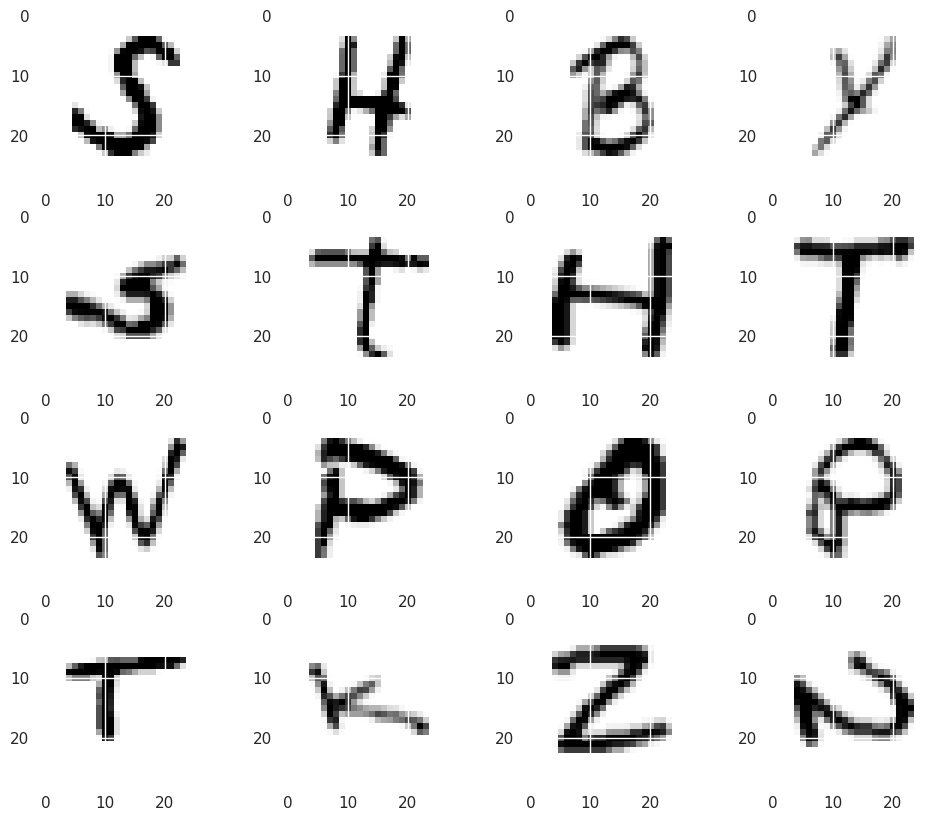

In [4]:
from sklearn.utils import shuffle

X_shuffle = shuffle(X)

plt.figure(figsize = (12,10))
row, colums = 4, 4
for i in range(16):  
    plt.subplot(colums, row, i+1)
    plt.imshow(X_shuffle.iloc[i].values.reshape(28,28),interpolation='nearest', cmap='Greys')
plt.show()

Amount of each labels


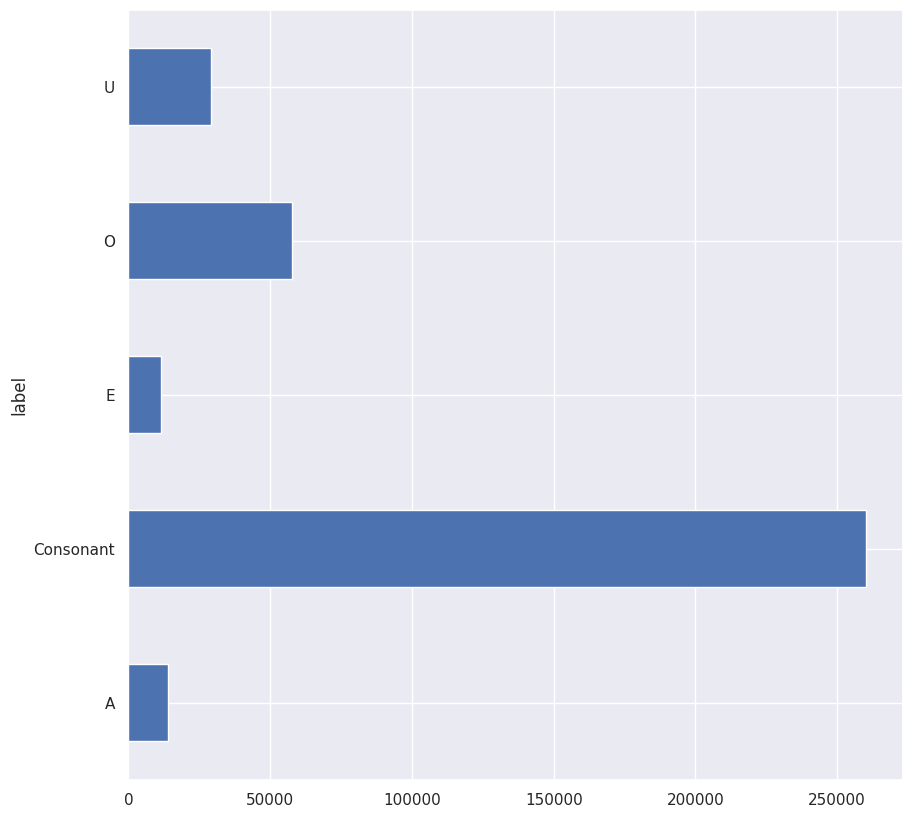

In [5]:
print("Amount of each labels")

# Change label to alphabets
alphabets_mapper = {0:'A',1:'Consonant',2:'Consonant',3:'Consonant',4:'E',5:'Consonant',6:'Consonant',7:'Consonant',8:'Consonant',9:'Consonant',10:'Consonant',11:'Consonant',12:'Consonant',13:'Consonant',14:'O',15:'Consonant',16:'Consonant',17:'Consonant',18:'Consonant',19:'Consonant',20:'U',21:'Consonant',22:'Consonant',23:'Consonant',24:'Consonant',25:'Consonant'} 
dataset_alphabets = dataset.copy()
dataset['label'] = dataset['label'].map(alphabets_mapper)

label_size = dataset.groupby('label').size()
label_size.plot.barh(figsize=(10,10))
plt.show()

In [6]:
print("A count:", label_size['A'])
print("E count:", label_size['E'])
print("O count:", label_size['O'])
print("U count:", label_size['U'])
print("Consonant count:", label_size['Consonant'])

A count: 13869
E count: 11440
O count: 57825
U count: 29008
Consonant count: 260308


**Pre-process the data**

In [7]:
# Splite data the feature and label
X = dataset.drop('label',axis = 1)
y = dataset['label']

print("shape:",X.shape)
print("culoms count:",len(X.iloc[1]))
print("784 = 28X28")

X.head()

shape: (372450, 784)
culoms count: 784
784 = 28X28


,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.10,...,0.639,0.640,0.641,0.642,0.643,0.644,0.645,0.646,0.647,0.648
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# Undersampling the data to overcome imbalanced dataset problem

rus = RandomUnderSampler(random_state=1513215)

X_resampled, y_resampled = rus.fit_resample(X, y)

print("Before resampling:\n", y.value_counts())
print("After resampling:\n", y_resampled.value_counts())

Before resampling:
 Consonant    260308
O             57825
U             29008
A             13869
E             11440
Name: label, dtype: int64
After resampling:
 A            11440
Consonant    11440
E            11440
O            11440
U            11440
Name: label, dtype: int64


In [9]:
# X_resampled = np.reshape(X_resampled.values, (X_resampled.shape[0], 28,28,1))
# X_resampled.shape

In [10]:
# Split train 80% and test 20%
x_train,x_test,y_train,y_test = train_test_split(X_resampled, y_resampled, test_size = 0.2, random_state = 1513215)
x_train.shape,x_test.shape

((45760, 784), (11440, 784))

In [11]:
# reshape the data for CNN model 28x28 pixel
x_train = np.reshape(x_train.values, (x_train.shape[0], 28,28))
x_test = np.reshape(x_test.values, (x_test.shape[0], 28,28))

In [12]:
# add color channel
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],x_train.shape[2],1)
print("New shape of train data: ", x_train.shape)

x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2],1)
print("New shape of test data: ", x_test.shape)

New shape of train data:  (45760, 28, 28, 1)
New shape of test data:  (11440, 28, 28, 1)


In [13]:
# label_map = {'A': 0, 'E': 1, 'I': 2, 'O': 3, 'U': 4, 'Consonant':5}
# label_map = {'A': 0, 'E': 1, 'O': 2, 'U': 3}

In [14]:
# One hot encoding for catergorial data
label_map = {'A': 0, 'E': 1, 'O': 2, 'U': 3, 'Consonant':4}

y_train_int = [label_map[label] for label in y_train]
y_test_int = [label_map[label] for label in y_test]

train_yOHE = to_categorical(y_train_int, num_classes = 5)
print("New shape of train labels: ", train_yOHE.shape)

test_yOHE = to_categorical(y_test_int, num_classes = 5)
print("New shape of test labels: ", test_yOHE.shape)

New shape of train labels:  (45760, 5)
New shape of test labels:  (11440, 5)


In [15]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [16]:
data_aug = Sequential(layers=[
    Input(shape=(28, 28, 1), name="InputLayer"),
    RandomFlip(mode='horizontal_and_vertical', name="RandomFlip"),
    RandomRotation(factor=10, fill_mode='reflect', name="RandomRotation"),
], name="DataAugmetor")

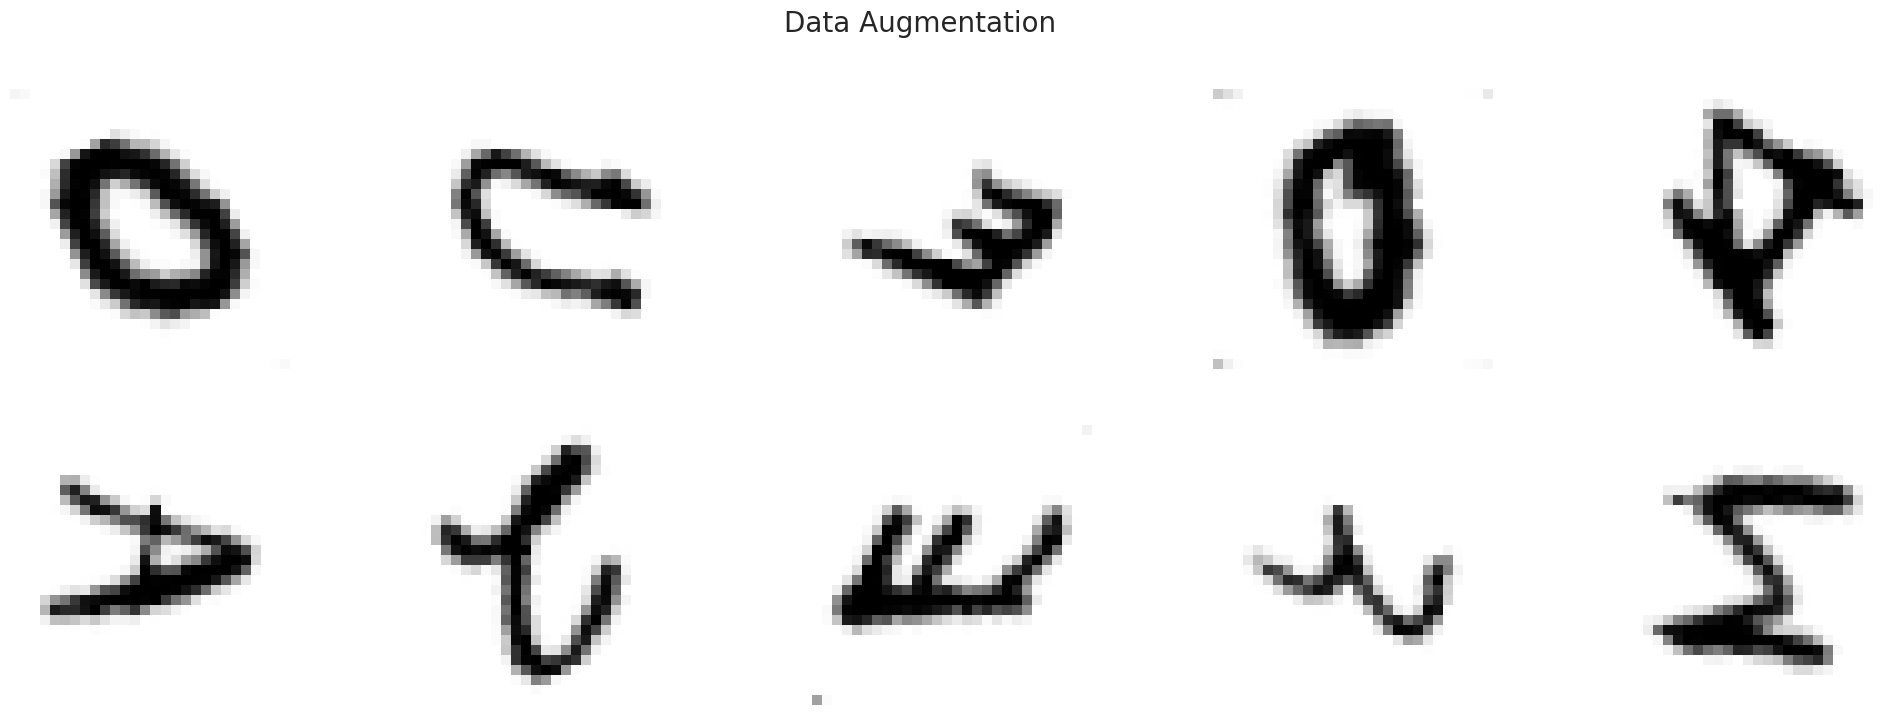

In [17]:
aug_images = data_aug(x_train[:10])

plt.figure(figsize=(25,8))
plt.suptitle("Data Augmentation", fontsize=20)
for i in range(len(aug_images)):
    plt.subplot(2,5,i+1)
    plt.imshow(aug_images[i],interpolation='nearest', cmap='Greys')
    plt.axis('off')
plt.show()

**Build CNN Model**

In [18]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'valid'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Flatten())

model.add(Dense(64,activation ="relu"))
model.add(Dense(128,activation ="relu"))

model.add(Dense(5,activation ="softmax"))

In [19]:
# Complie and train the model for 5 epochs
model.compile(optimizer = Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy', precision_m, recall_m, f1_m])

history = model.fit(x_train, train_yOHE, batch_size=128, epochs=9,  validation_data = (x_test,test_yOHE))

Epoch 1/9
358/358 [==============================] - 13s 9ms/step - loss: 0.3423 - accuracy: 0.9197 - precision_m: 0.9270 - recall_m: 0.9123 - f1_m: 0.9193 - val_loss: 0.0699 - val_accuracy: 0.9767 - val_precision_m: 0.9777 - val_recall_m: 0.9761 - val_f1_m: 0.9769
Epoch 2/9
358/358 [==============================] - 2s 6ms/step - loss: 0.0567 - accuracy: 0.9810 - precision_m: 0.9820 - recall_m: 0.9805 - f1_m: 0.9812 - val_loss: 0.0533 - val_accuracy: 0.9825 - val_precision_m: 0.9830 - val_recall_m: 0.9824 - val_f1_m: 0.9827
Epoch 3/9
358/358 [==============================] - 2s 6ms/step - loss: 0.0382 - accuracy: 0.9875 - precision_m: 0.9879 - recall_m: 0.9872 - f1_m: 0.9876 - val_loss: 0.0596 - val_accuracy: 0.9812 - val_precision_m: 0.9815 - val_recall_m: 0.9808 - val_f1_m: 0.9812
Epoch 4/9
358/358 [==============================] - 3s 8ms/step - loss: 0.0294 - accuracy: 0.9903 - precision_m: 0.9907 - recall_m: 0.9902 - f1_m: 0.9904 - val_loss: 0.0448 - val_accuracy: 0.9861 - val_p

In [20]:
# Save the model
model.summary()
# model.save(r'aeou_model.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 128)        0

**Evaluate the mode**

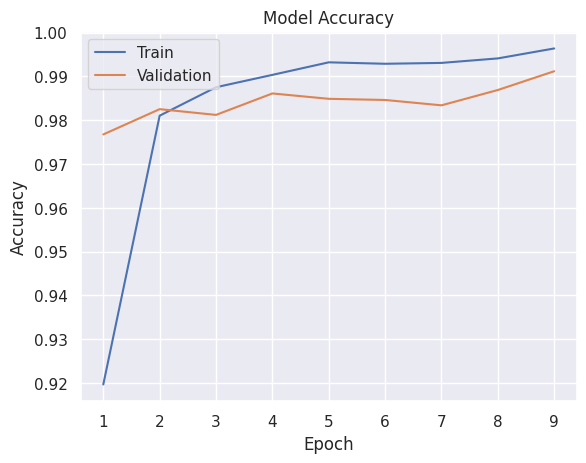

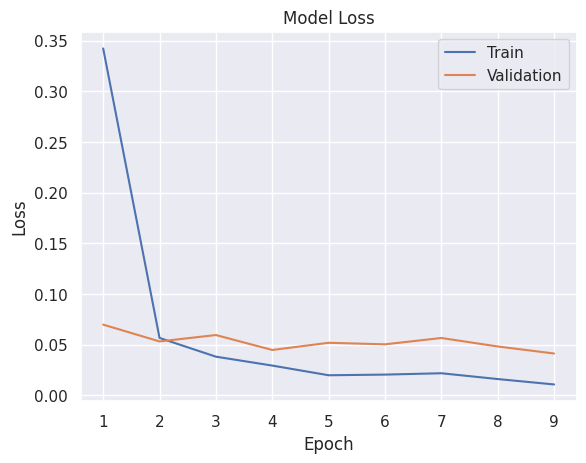

In [21]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.xticks(range(len(history.history['accuracy'])), range(1, len(history.history['accuracy'])+1))
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.xticks(range(len(history.history['loss'])), range(1, len(history.history['loss'])+1))
plt.show()

# # Plot the training and validation precision
# plt.plot(history.history['precision_m'])
# plt.plot(history.history['val_precision_m'])
# plt.title('Model Precision')
# plt.ylabel('Precision')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.xticks(range(len(history.history['precision_m'])), range(1, len(history.history['precision_m'])+1))
# plt.show()

# # Plot the training and validation recall
# plt.plot(history.history['recall_m'])
# plt.plot(history.history['val_recall_m'])
# plt.title('Model Recall')
# plt.ylabel('Recall')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.xticks(range(len(history.history['recall_m'])), range(1, len(history.history['recall_m'])+1))
# plt.show()

# # Plot the training and validation F1
# plt.plot(history.history['f1_m'])
# plt.plot(history.history['val_f1_m'])
# plt.title('Model F1')
# plt.ylabel('F1')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.xticks(range(len(history.history['f1_m'])), range(1, len(history.history['f1_m'])+1))
# plt.show()

358/358 [==============================] - 1s 3ms/step


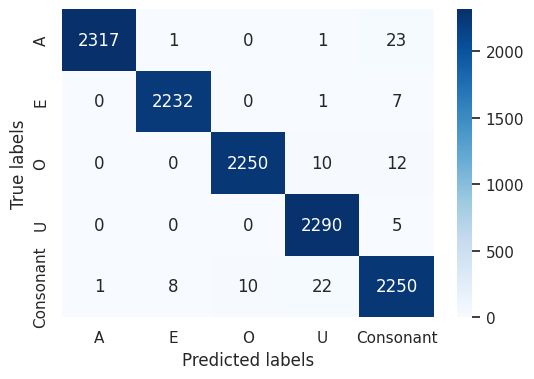

In [22]:
#Plot confusion matrix

word_dict = {0: 'A', 1: 'E', 2: 'O', 3: 'U', 4:'Consonant'}

y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

# Get the true labels
y_true = np.argmax(test_yOHE, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

word_dict[np.argmax(test_yOHE[i])]
# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=word_dict.values(), yticklabels=word_dict.values(), fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

358/358 [==============================] - 1s 2ms/step


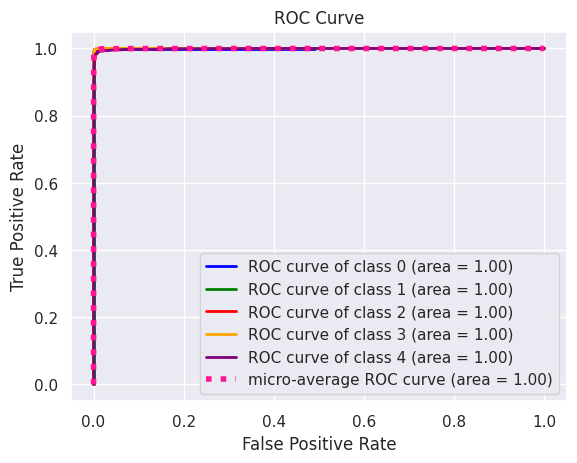

In [23]:
# Make predictions on the test set

y_pred = model.predict(x_test)

# Compute ROC curve and ROC area for each class
n_classes = 5
fpr = {}
tpr = {}
roc_auc = {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_yOHE[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test_yOHE.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class
plt.figure()
lw = 2
colors = ['blue', 'green', 'red', 'orange', 'purple']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
         ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

1/1 [==============================] - 0s 19ms/step


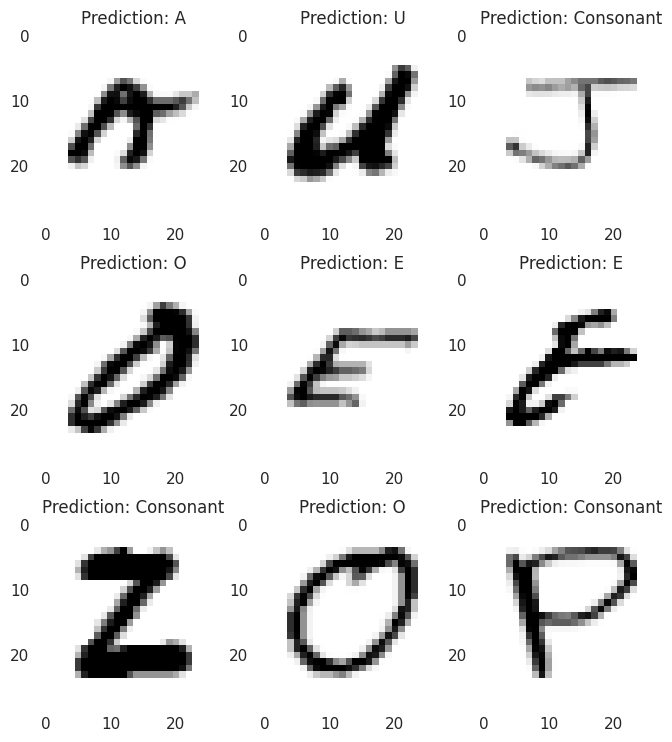

In [24]:
fig, axes = plt.subplots(3,3, figsize=(8,9))
axes = axes.flatten()

for i,ax in enumerate(axes):
    img = np.reshape(x_test[i], (28,28)) # reshaping it for displaying
    ax.imshow(img, cmap="Greys")
    img_final =np.reshape(img, (1,28,28,1)) # reshapng it for passing into model for prediction
    pred = word_dict[np.argmax(model.predict(img_final))]
    ax.set_title("Prediction: "+pred)
    ax.grid()

In [25]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test_int, y_pred))

358/358 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2342
           1       1.00      1.00      1.00      2240
           2       1.00      0.99      0.99      2272
           3       0.99      1.00      0.99      2295
           4       0.98      0.98      0.98      2291

    accuracy                           0.99     11440
   macro avg       0.99      0.99      0.99     11440
weighted avg       0.99      0.99      0.99     11440



In [26]:
# Calculate accuracy for train set
train_loss, train_acc, train_f1_score, train_precision, train_recall = model.evaluate(x_train, train_yOHE, verbose=0)
print("Train Accuracy:", train_acc)

# Calculate accuracy for test set
test_loss, test_acc, test_f1_score, test_precision, test_recall = model.evaluate(x_test, test_yOHE, verbose=0)
print("Test Accuracy:", test_acc)


Train Accuracy: 0.997683584690094
Test Accuracy: 0.9911713004112244
